# Modelos: KNN

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import sys
sys.path.append('../lib')

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import random

## Setup

In [8]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [9]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

In [10]:
pu.get_device()

device(type='cuda', index=0)

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.__version__

'1.11.0'

In [13]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

<torch._C.Generator object at 0x7f8791735490>

## Carga de dataset

In [14]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2000) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199144 entries, 0 to 199143
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      199144 non-null  int64         
 1   user_seq                     199144 non-null  int64         
 2   user_movie_tags              199144 non-null  object        
 3   user_movie_rating            199144 non-null  int64         
 4   user_movie_rating_timestamp  199144 non-null  datetime64[ns]
 5   user_movie_rating_year       199144 non-null  int64         
 6   movie_id                     199144 non-null  int64         
 7   movie_seq                    199144 non-null  int64         
 8   movie_title                  199144 non-null  string        
 9   movie_genres                 199144 non-null  object        
 10  movie_for_adults             199144 non-null  bool          
 11  movie_original_language   

In [15]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2022-05-29 11:41:43,195 - INFO - Train: 84.36 % - Test: 7.43 %


## Entrenamiento del modelo

In [16]:
user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

Building Ratting Matrix:   0%|          | 0/168004 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/13057 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

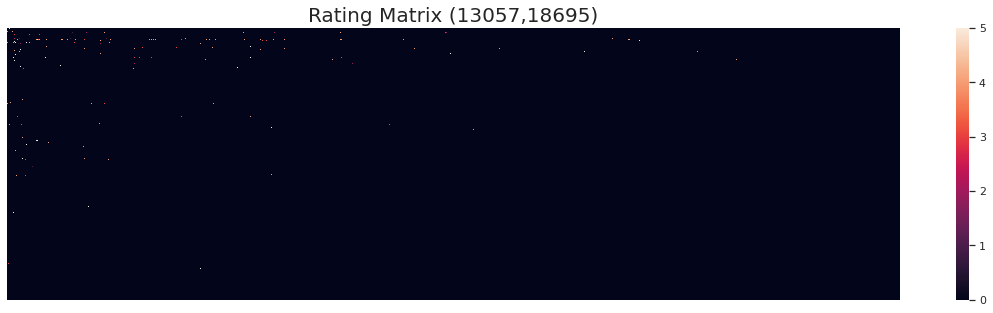

<Figure size 720x720 with 2 Axes>

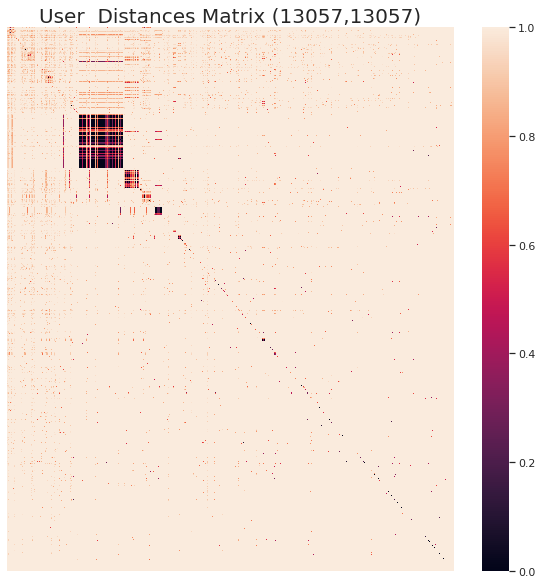

In [51]:
user_predictor.plot()

In [17]:
item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
    data          = train_set.data,
    user_seq_col  = 'user_seq',
    movie_seq_col = 'movie_seq',
    rating_col    = 'user_movie_rating',
    distance      = ml.CosineDistance()
)

Building Ratting Matrix:   0%|          | 0/168004 [00:00<?, ?it/s]

Building Distances Matrix:   0%|          | 0/18695 [00:00<?, ?it/s]

<Figure size 720x720 with 2 Axes>

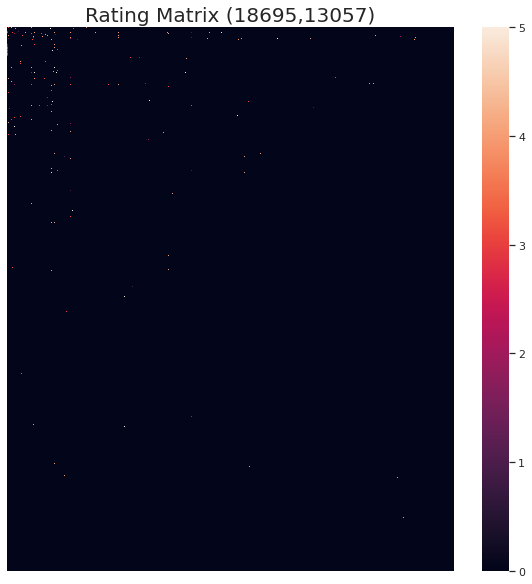

<Figure size 720x720 with 2 Axes>

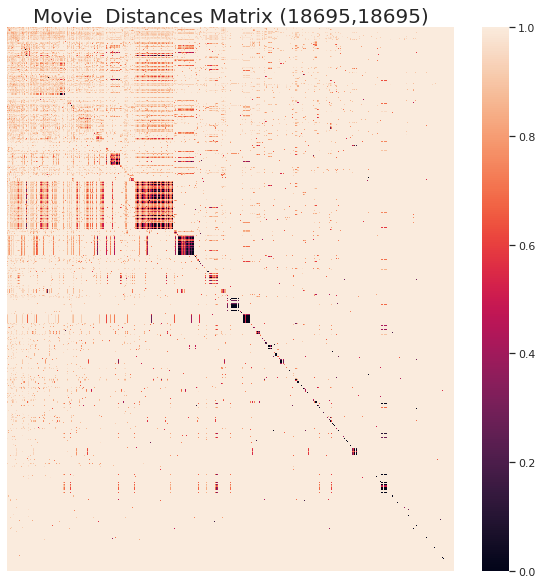

In [52]:
item_predictor.plot()

Decoramos los predictores un con cache para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos donde el resultado no es aleatorio:

In [47]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [55]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

## Validación del modelo

In [38]:
def validation(predictors, n_samples=100, batch_size=1000, n_neighbors=100):
    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics    = [
            mt.RMSE(),
            mt.MeanAveragePrecisionAtk(user_index=0, k=5, discretizer=dr.between(4, 5))
        ],
        predictors = predictors
    )
    summary = validator.validate(eval_set, n_neighbors=n_neighbors)

    summary.save('../metrics/knn')
    summary = ml.ValidatorSummary.load('../metrics/knn')
    summary.plot(bins=12, show_table=True)

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

<Figure size 1440x360 with 2 Axes>

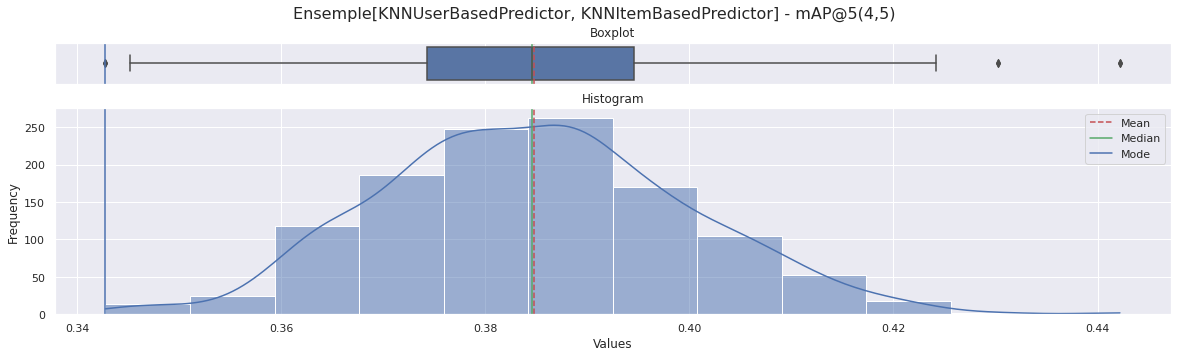


Metrics:



,"mAP@5(4,5)"
count,1200.000000
mean,0.384819
std,0.015066
min,0.342779
25%,0.374289
50%,0.384570
75%,0.394542
max,0.442196


<Figure size 1440x360 with 2 Axes>

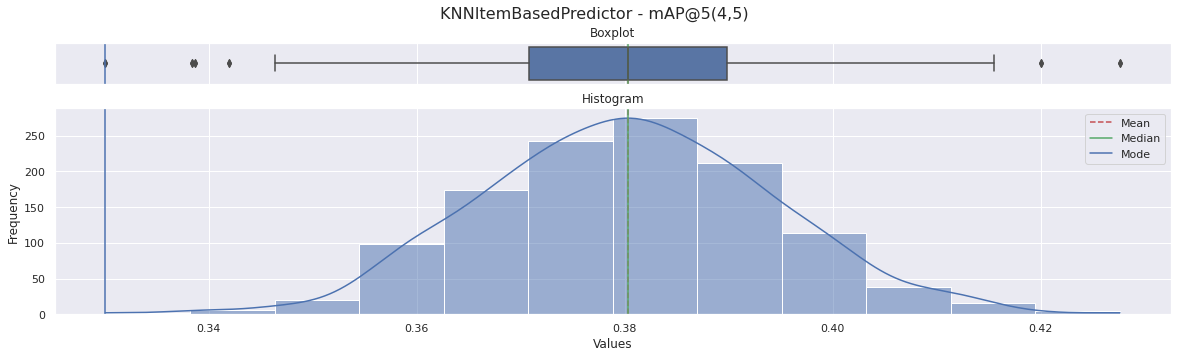


Metrics:



,"mAP@5(4,5)"
count,1200.000000
mean,0.380327
std,0.014056
min,0.330065
25%,0.370798
50%,0.380284
75%,0.389869
max,0.427613


<Figure size 1440x360 with 2 Axes>

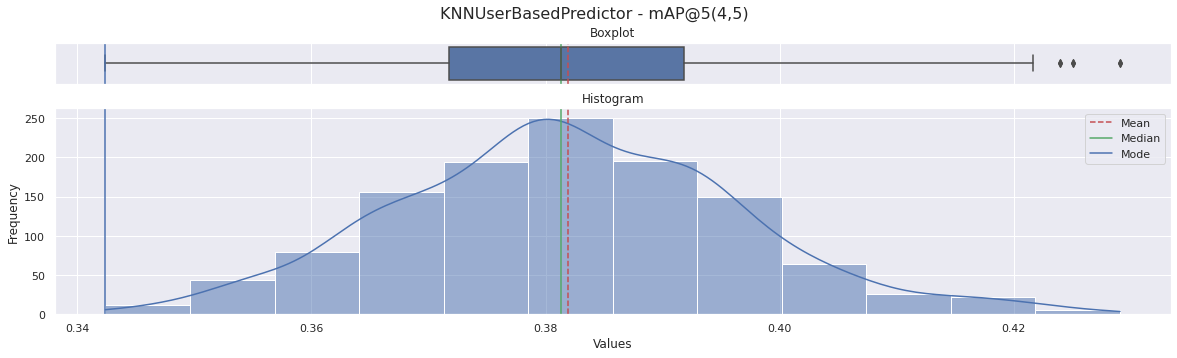


Metrics:



,"mAP@5(4,5)"
count,1200.000000
mean,0.381943
std,0.014709
min,0.342399
25%,0.371788
50%,0.381297
75%,0.391789
max,0.429061


<Figure size 1440x360 with 2 Axes>

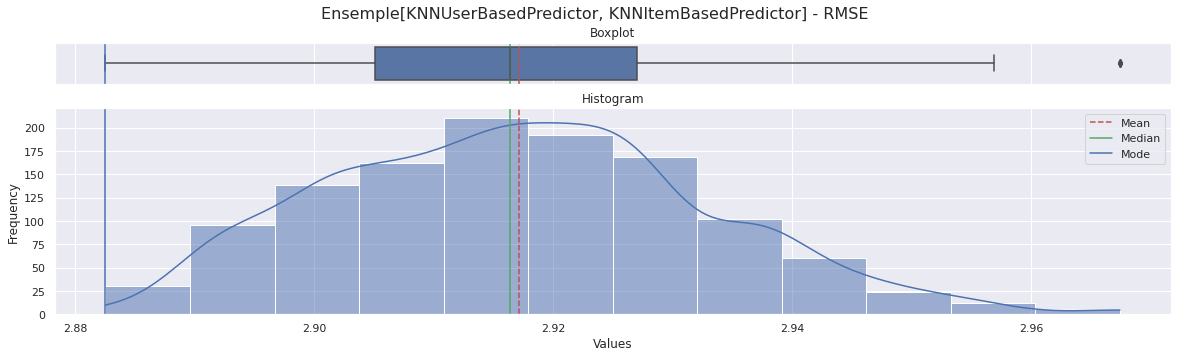


Metrics:



,RMSE
count,1200.000000
mean,2.917146
std,0.015642
min,2.882545
25%,2.905080
50%,2.916418
75%,2.927024
max,2.967404


<Figure size 1440x360 with 2 Axes>

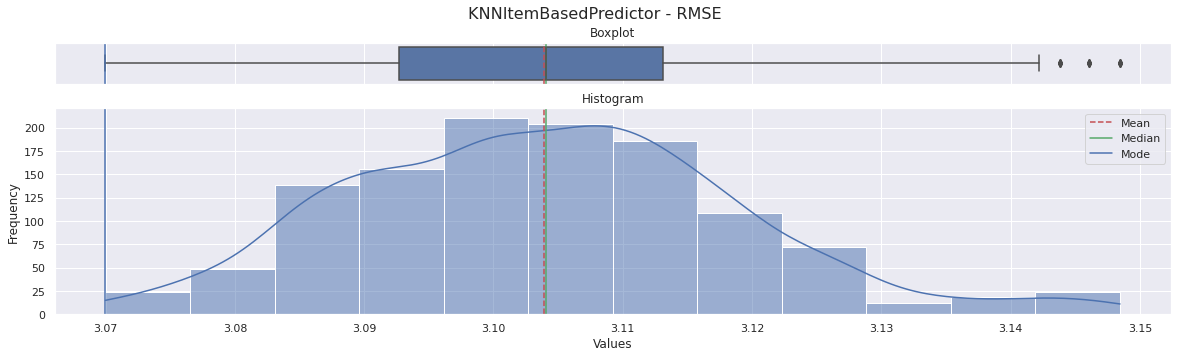


Metrics:



,RMSE
count,1200.000000
mean,3.103917
std,0.014975
min,3.069987
25%,3.092720
50%,3.104068
75%,3.113148
max,3.148456


<Figure size 1440x360 with 2 Axes>

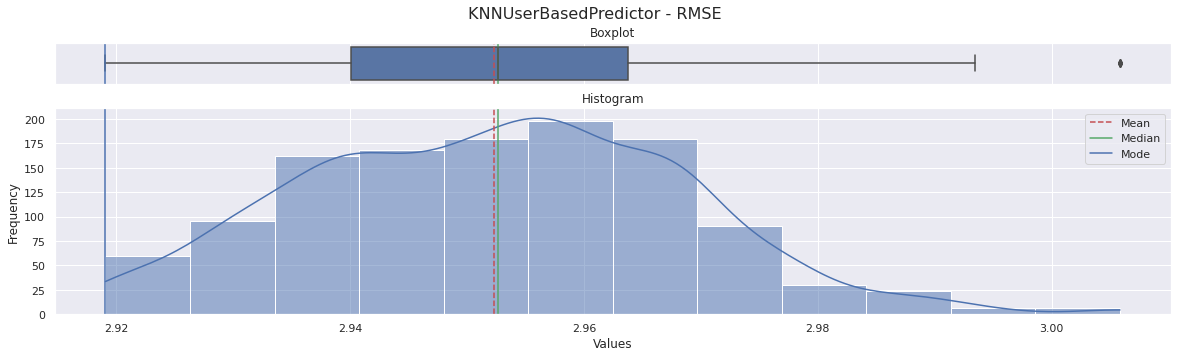


Metrics:



,RMSE
count,1200.000000
mean,2.952305
std,0.016170
min,2.919070
25%,2.940042
50%,2.952661
75%,2.963737
max,3.005850


<Figure size 1440x360 with 2 Axes>

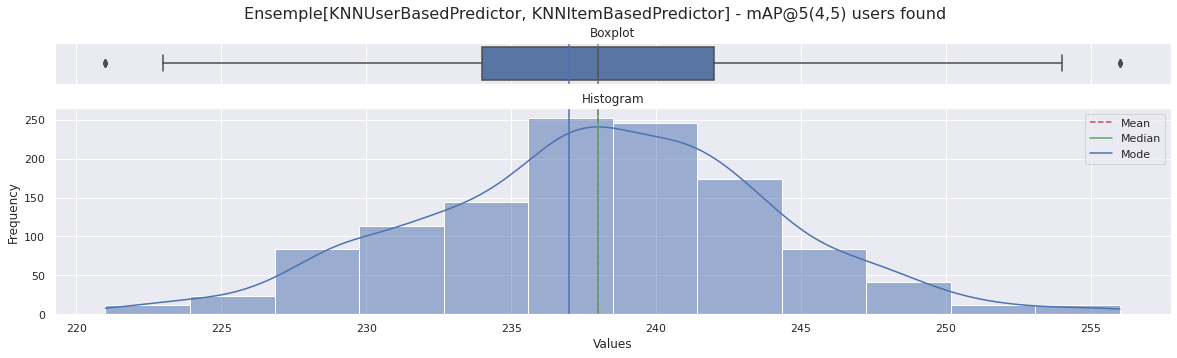


Metrics:



,"mAP@5(4,5) users found"
count,1200.000000
mean,238.000000
std,6.069654
min,221.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,256.000000


<Figure size 1440x360 with 2 Axes>

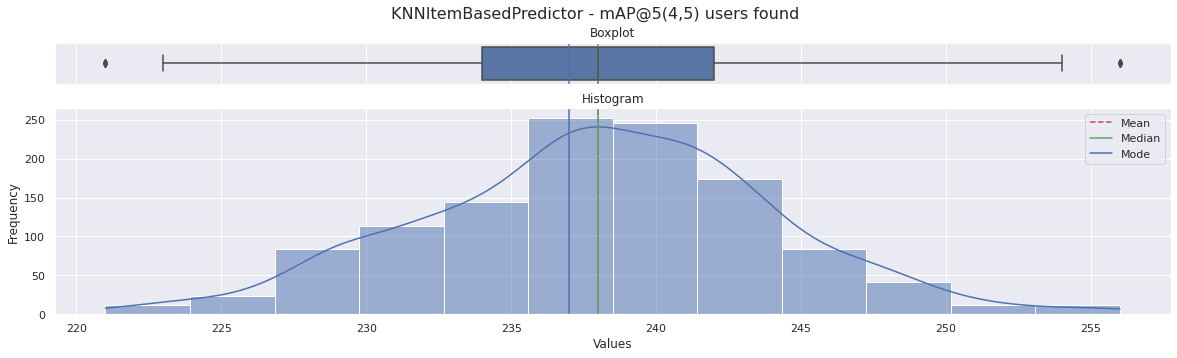


Metrics:



,"mAP@5(4,5) users found"
count,1200.000000
mean,238.000000
std,6.069654
min,221.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,256.000000


<Figure size 1440x360 with 2 Axes>

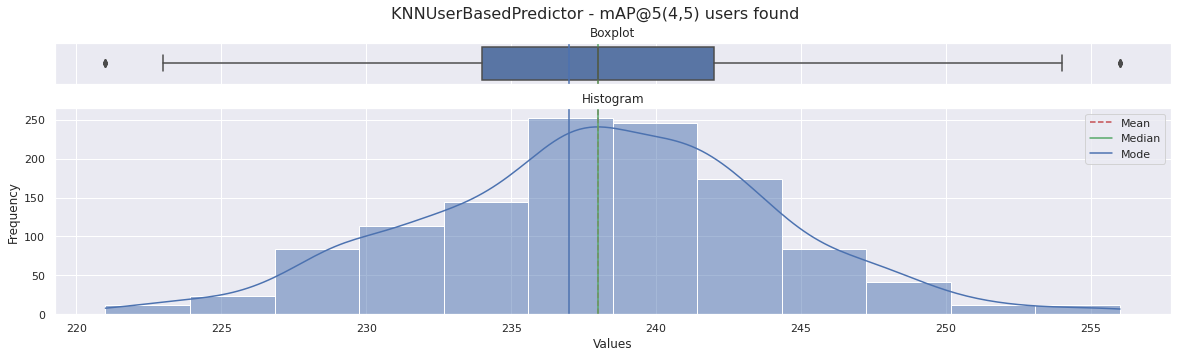


Metrics:



,"mAP@5(4,5) users found"
count,1200.000000
mean,238.000000
std,6.069654
min,221.000000
25%,234.000000
50%,238.000000
75%,242.000000
max,256.000000


In [56]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples   = 200,
    batch_size  = 5000,
    n_neighbors = 5000
)